In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt


from standard_precip.spi import SPI
from standard_precip.utils import plot_index
from standard_precip import spi
#warning
import warnings
warnings.filterwarnings('ignore')

dir_in = 'D:/Xanthos-Repo/Data for Figures-Xanthos WM'

In [2]:
#############################################################
# Xanthos grid info
basinName = pd.read_csv(dir_in + '/BasinNames235.txt')
basin_id = pd.read_csv(dir_in + '/basin.csv')
#GRDC list
GRDC_xanthosCoordIndx = pd.read_csv(dir_in + '/GRDC_stations_list.csv')
#GRDC data
grdc_basin_m3persec  =  pd.read_csv(dir_in + '/grdc_91basin_m3persec_1971_1990_monthly.csv')
##
nbasins = GRDC_xanthosCoordIndx.shape[0]
basins91 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_91 = [basinName['Basin_Name'][basins91[ii] - 1] for ii in range(nbasins)]

In [3]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    import numpy as np
    from datetime import date, timedelta
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')

    return data_ts

## Calibration

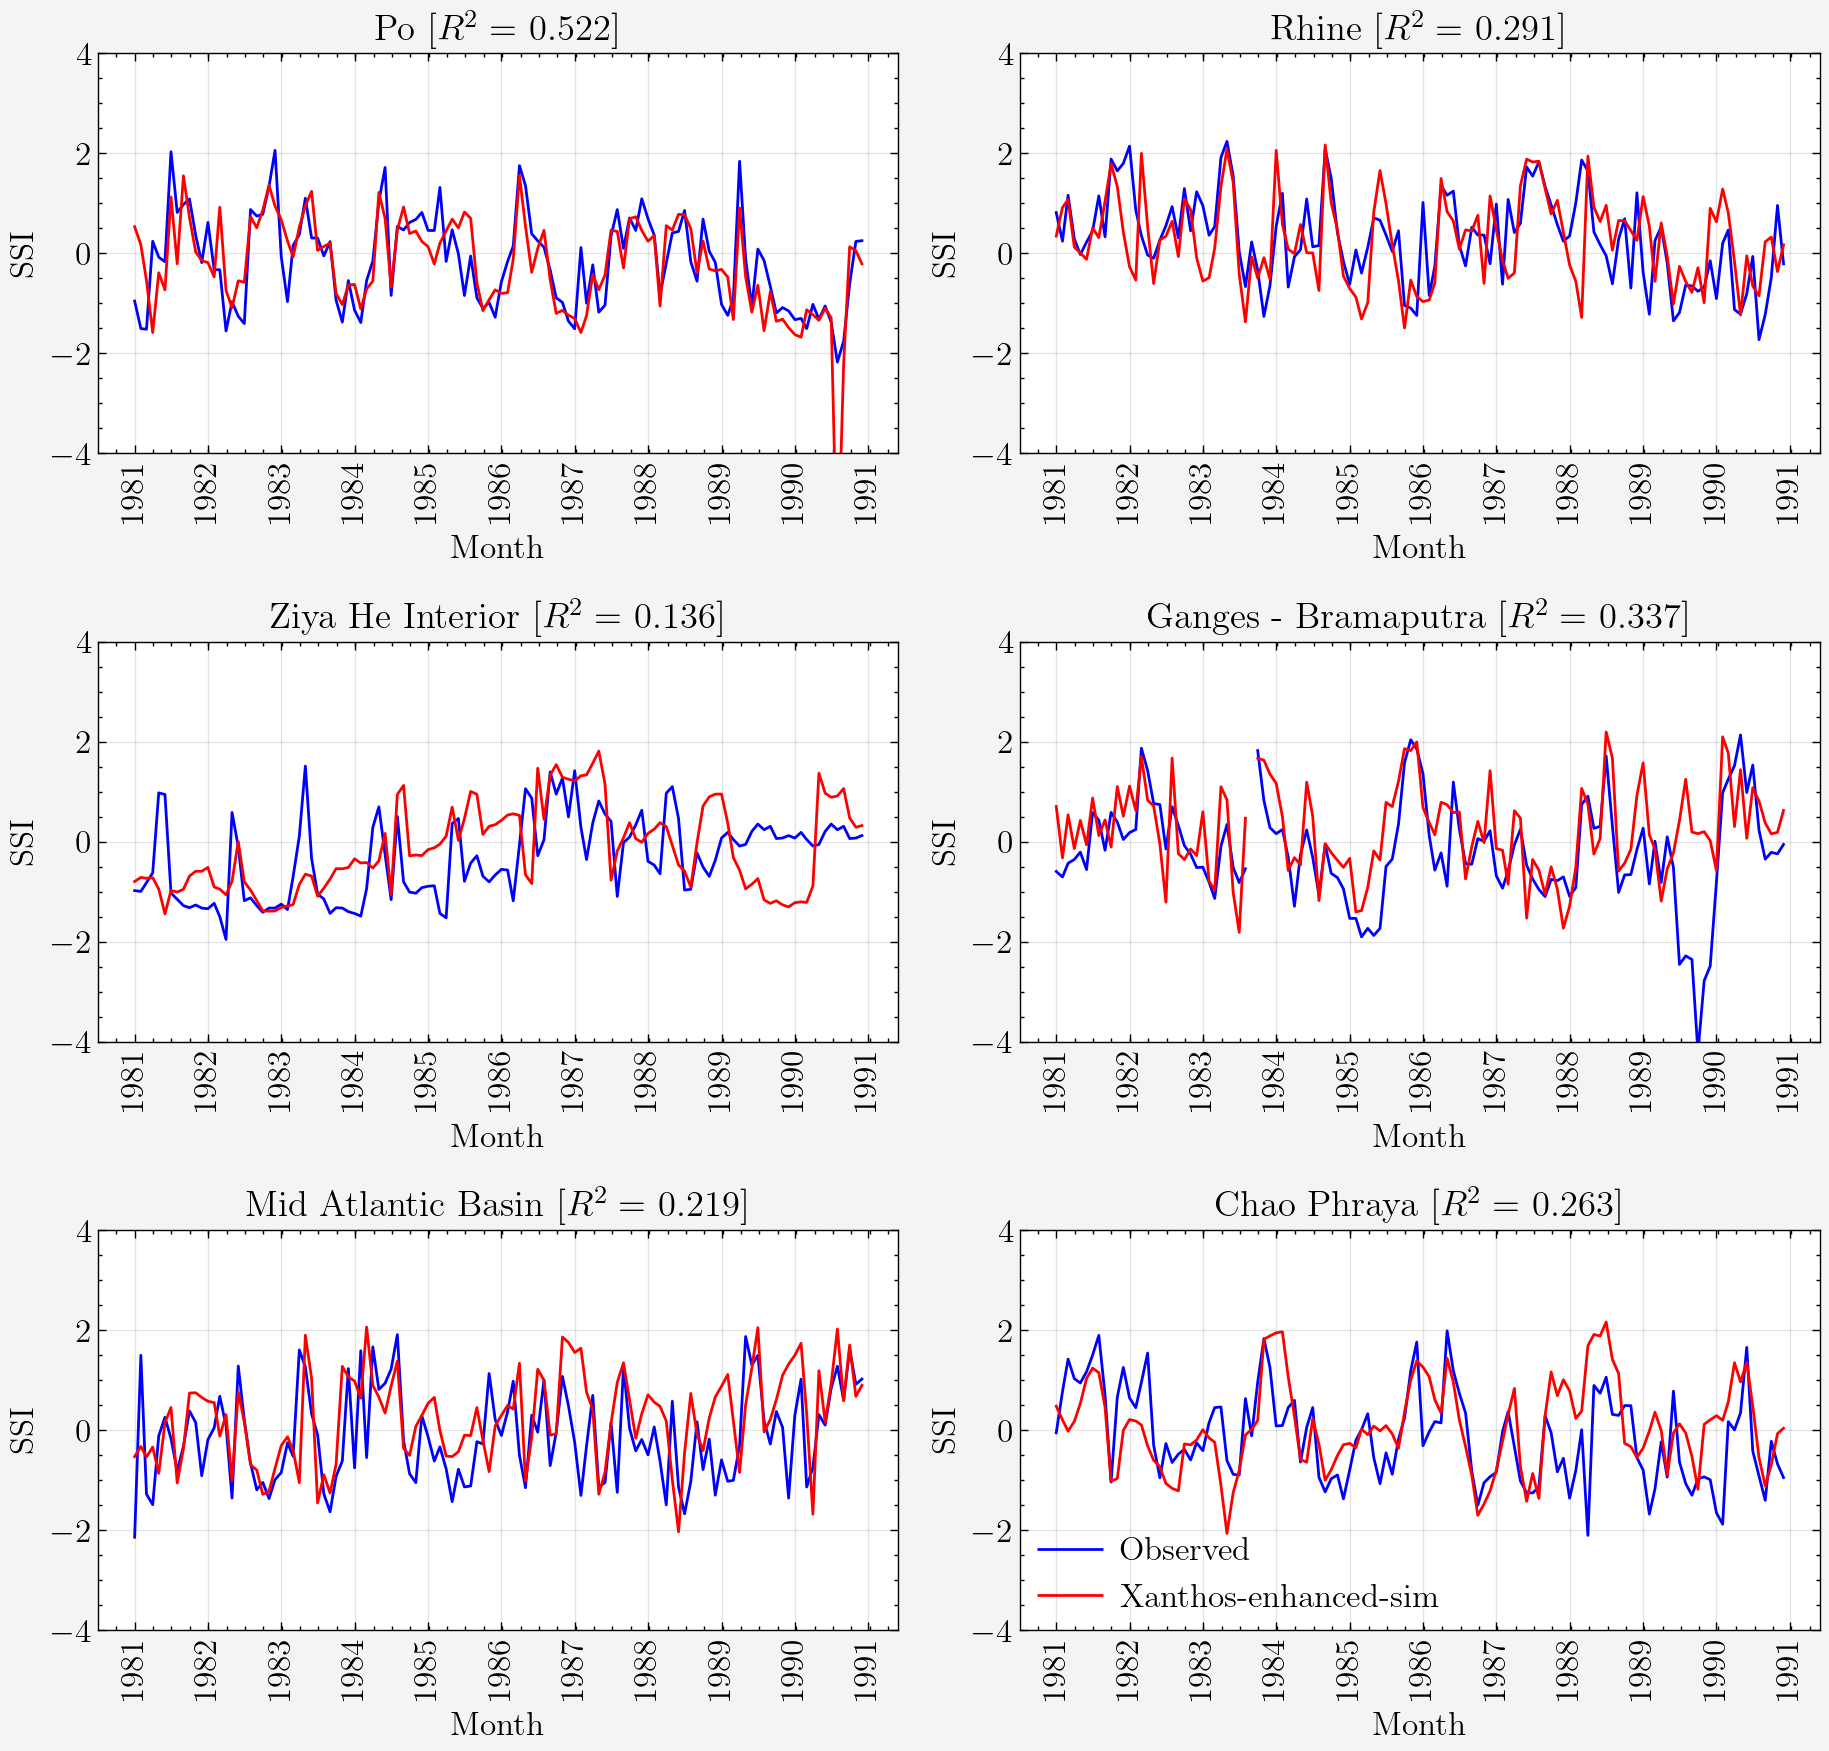

In [4]:
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12}) 
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}


file_dir_watch_vald = dir_in + '/Simulated/SimulatedFinal-HP/flow/'
file_dir_watch_natr = dir_in + '/Simulated/SimulatedFinal-YL/flow/'

basin_slt = [57, 32, 77, 110, 233, 146]
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):

    fig, ax = pplt.subplots(ncols=2, nrows=3,refaspect=1, refheight=2.0, refwidth=4.0, share=0)
    for jj in range(6):
        basin_num = basin_slt[jj]    
        ii = np.where(basins91==basin_num)[0][0]
        basin_num = basins91[ii]    

        ## observed
        aa = (grdc_basin_m3persec['basin'] == basin_num)
        grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
        qobs_calibration_ts = timeseries_coverter(grdc_m3persec, start_yr=1971, ending_yr=1990)
        qobs_calibration_ts.columns = ['Q']
        qobs_calibration_ts['date'] = qobs_calibration_ts.index

        # SDI
        sdi_new= spi.SPI()
        df_sdi_obs = sdi_new.calculate(qobs_calibration_ts, 
                                    'date', 
                                    'Q', 
                                    freq="M", 
                                    scale=1, 
                                    fit_type="lmom", 
                                    dist_type="gev")

        df_sdi_obs.index = df_sdi_obs.date
        df_sdi_obs.set_index('date')    
        df_sdi_obs_data = df_sdi_obs.drop(['date','Q'], 1)
        ###############################
        ## simulated
        data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy') 
        qsim_calibration_ts = timeseries_coverter(data_basin, start_yr=1971, ending_yr=1990)
        qsim_calibration_ts.columns = ['Q']
        qsim_calibration_ts['date'] = qsim_calibration_ts.index    
        sdi_new= spi.SPI()
        df_sdi_sim = sdi_new.calculate(qsim_calibration_ts, 
                                    'date', 
                                    'Q', 
                                    freq="M", 
                                    scale=1, 
                                    fit_type="lmom", 
                                    dist_type="gev")

        df_sdi_sim.index = df_sdi_sim.date
        df_sdi_sim.set_index('date')
        df_sdi_sim_data = df_sdi_sim.drop(['date','Q'], 1)

        x = np.array(df_sdi_obs_data['1981-01-01':'1990-12-01'])
        y = np.array(df_sdi_sim_data['1981-01-01':'1990-12-01'])
        zxy = ~(np.isnan(x) | np.isnan(y))
        
        kge_cal = spotpy.objectivefunctions.rsquared(x[zxy], y[zxy])
    
        ## plotting
        ax[jj].plot(df_sdi_obs_data['1981-01-01':'1990-12-01'], 'b', label='Observed')
        ax[jj].plot(df_sdi_sim_data['1981-01-01':'1990-12-01'], 'r', label='Xanthos-enhanced-sim')
        #ax[jj].format(ylabel = 'SDI', xlabel = 'Month', title = basinName_94[ii])
        ax[jj].format(ylabel = 'SSI', xlabel = 'Month', title = basinName_91[ii] + ' $[R^{2}= $ '+ str(np.round(kge_cal,3))  +']')
        ax[jj].set_ylim([-4,4])

        if jj==5:
            ax[jj].legend(ncols=1)

plt.tight_layout()
#dir_out = 'D:\\Xanthos-Repo\\figures\\'
#plt.savefig("dir_out + Figure-11.png", **SAVE_KWDS)   